<a href="https://colab.research.google.com/github/Lewis34cs/corona_audio/blob/main/covid_proj_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project Part 1

Author: Chris Lewis

Contact info: lewis34cs@gmail.com

Link to Github repo: https://github.com/Lewis34cs/corona_audio

#### COVID-19 Exploration in statistics and diagnosis via imaging and audio

>Since the beginning of 2020, COVID-19 has run rampant throughout the entirety of the globe, resulting in over 100 million cases and 2 million deaths. While vaccines are beginning to be pushed out as our new line of defense, my project's goal is to try and identify other ways to detect COVID-19 in a patient to help slow the spread. In this project, I focus on two different ways to identify COVID-19: multi classification via chest x-rays and binary classification through coughing audio. Both parts will be using Sequential Convolutional Neural Networks. 

>To run the Google Colab code, you must allow Google Colab to access an account. I will provide links for the data below. Please be sure to save zipped folders for these audio datasets into your google drive so you can access them on Google Colab. The chest x-ray database was obtained via Kaggle's API.

**Chest X-ray Database**: 
1. https://www.kaggle.com/tawsifurrahman/covid19-radiography-database


**Audio Datasets Original Sources**:
1. Virufy dataset - Original source: https://github.com/virufy/virufy_data
2. CoughVid dataset - Original source: https://zenodo.org/record/4048312#.YBnSHOhKhPY



---
Link for functions and zipped audio datasets: https://drive.google.com/drive/folders/1IQ758RksB0ayUhOohfGh8s25MT4taMsI?usp=sharing


Click on the "add to drive" button once you've clicked on the Google Drive link above to add the datasets and functions to your Google Drive
<img src='https://drive.google.com/uc?id=1YYdx9_xhHRsYLqV2X7yUJauG9zKX_LoX'>

Mounting Google Drive

In [1]:
# We must run this in order for colab to be able to access our google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# We need to import these libraries in order to access the shared folder
import os, sys

In [3]:
# We must install these libraries for our imported functions folder to work
!pip install split-folders
!pip install split-folders tqdm
!pip install pydub
!pip install soundfile
!pip install ffmpeg-python
!pip install zip_files
!pip install lime

     |████████████████████████████████| 276kB 8.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=9c225dddcc146874d1ad7e6d9b575225b480345f3e6d0efc0d9692707d010207
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [100]:
# Set the FOLDER variable as the filepath where the folder containing functions 
#and audio datasets are located in your Google Drive
FOLDER = '/content/drive/MyDrive/chris_lewis_capstone/'
os.listdir(FOLDER)

['public_dataset.zip', 'virufy_data-main.zip', '__pycache__', 'functions.py']

In [101]:
# Defining a path variable (our FOLDER) to add a specific path for the 
# interpreter to search
sys.path.append(FOLDER)

In [102]:
%load_ext autoreload
%autoreload 2
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Importing Libraries

In [13]:
#Setting seeds first in order to achieve better consistency in scoring
import numpy as np
import tensorflow as tf

np.random.seed(321)
tf.random.set_seed(321)

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os, sys, glob, shutil

In [15]:
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
from skimage.segmentation import mark_boundaries
import time
from IPython.display import Image, display
from PIL import Image as Im
import cv2
import shutil
from google.colab import files

# tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [17]:
import splitfolders
import lime
from lime import lime_image
from zipfile import ZipFile

In [7]:
# setting plot background style
plt.style.use('dark_background')

# PART 1: Classifying COVID-19 Chest X-ray Images via Sequential Convolutional Neural Network

In [8]:
# Viewing where we are in the directory
os.path.abspath(os.curdir)

'/content'

## Obtaining COVID CXR dataset via Kaggle API

For instructions on how to get an API key: https://www.kaggle.com/docs/api

In [9]:
# Hiding my key by having a variable store the info
API_key = files.upload()

Saving kaggle.json to kaggle.json


In [10]:
# Creating a hidden folder then copying my API key and putting it in that file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [11]:
# Permissions of 600 mean that I (the owner) have full read and write access to the 
# file, while no other user can access or edit the file
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
# Downloading the zipped dataset via Kaggle's API
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 1.13G/1.14G [00:07<00:00, 184MB/s]
100% 1.14G/1.14G [00:07<00:00, 154MB/s]


Unzipping Folder Contents

In [13]:
# Unzipping the file and extracting to the root directory
# If you chose to directly download the database from the kaggle page
# instead of making a call to the API, replace the 'f_name' variable
# with the location of the zipped file in your Google Drive
f_name = "covid19-radiography-database.zip"

with ZipFile(f_name, 'r') as zipf:
      zipf.extractall()
      print('Done')

Done


In [14]:
# removing unnecessary files
!rm /content/covid19-radiography-database.zip
!rm /content/kaggle.json

In [15]:
# Setting directory location to root directory
%cd ~
%cd ..

/root
/


In [16]:
# setting a variable called cxr_base_folder that contains the directory of where 
# our chest x-ray images are
cxr_base_folder = ensure_filepath('/content/COVID-19 Radiography Database')

In [17]:
# Viewing the contents within our cxr_base_folder
folder_contents(cxr_base_folder)

Contents of /content/COVID-19 Radiography Database/:



['COVID',
 'COVID.metadata.xlsx',
 'NORMAL',
 'NORMAL.metadata.xlsx',
 'README.md.txt',
 'Viral Pneumonia',
 'Viral Pneumonia.metadata.xlsx']

#### Identifying the number of images in our dataset

In [18]:
total_image_number = num_items(cxr_base_folder)

/content/COVID-19 Radiography Database/
Number of items in COVID: 1200
Number of items in NORMAL: 1341
Number of items in Viral Pneumonia: 1345
Total number of items: 3886


>From here, we view the extracted contents and count the number of images per class along with the total image count. We see that we are working with 3800+ images.

### Splitting our images into train, test, and validation sets

In [19]:
# making a temporary folder to store our train, test, and validation folders. 
# Please specify a filepath where you would like to store your train, test, and
# validation folders in the 'cxr_folders' variable. Note that this folder is 
# temporary.
cxr_folders = ensure_filepath('/content/cxr_folders')

os.makedirs(cxr_folders, exist_ok=True)

#### Temporary Folder Creation & Check

In [20]:
# Using the splitfolders library to split our images into train, test, and validation
# subfolders by our desired ratio, and placing these subfolders in a new directory

# source of how to run: https://github.com/jfilter/split-folders
run = 1
if run:
  splitfolders.ratio(input=cxr_base_folder, 
                    output=cxr_folders, 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio order: train, val, test
else:
  print('Did not run')

Copying files: 3886 files [00:03, 1181.74 files/s]


## Recommendation:

If you prefer working with folder structures when dealing with training and testing data, I would highly recommend using the splitfolders library. Through the use of this library, I was able to create train, test, and validation folders, create image data generators, and have those generators access the data by flowing the data from my directories. 

In [22]:
folder_check(new_dir=cxr_folders, orig_dir=cxr_base_folder, check=1)

/content/cxr_folders/train/
Number of items in Viral Pneumonia: 941
Number of items in NORMAL: 938
Number of items in COVID: 840
Total number of items: 2719

/content/cxr_folders/test/
Number of items in Viral Pneumonia: 270
Number of items in NORMAL: 269
Number of items in COVID: 240
Total number of items: 779

/content/cxr_folders/val/
Number of items in Viral Pneumonia: 134
Number of items in NORMAL: 134
Number of items in COVID: 120
Total number of items: 388

/content/COVID-19 Radiography Database/
Number of items in COVID: 1200
Number of items in NORMAL: 1341
Number of items in Viral Pneumonia: 1345
Total number of items: 3886

Are the image numbers equal?
True

Total image count: 3886


In [23]:
# Creating variables to hold our addresses for our train, test, and val folders
train_folder, test_folder, val_folder = create_ttv(cxr_folders)

In [24]:
train_folder

'/content/cxr_folders/train/'

In [25]:
TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, VAL_BATCH_SIZE = batch_sizes([train_folder, 
                                                                 test_folder, 
                                                                 val_folder])
print(f"Train batch size: {TRAIN_BATCH_SIZE}\nTest batch size: {TEST_BATCH_SIZE}"
      f"\nValidation batch size: {VAL_BATCH_SIZE}")

Train batch size: 2719
Test batch size: 779
Validation batch size: 388


#### Setting up ImageDataGenerators

In [26]:
# Defining our image size
IMG_SIZE = (128, 128)

# Creating ImageDataGenerators for train and test/val
train_datagen = ImageDataGenerator(rescale=1./255)
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
# Having each IDG using flow_from_directory by our defined batch sizes to create
# iterators that will spit out the entire set of data.
dummy_train_generator = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=TRAIN_BATCH_SIZE,
                                                   class_mode='categorical')

dummy_test_generator = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=TEST_BATCH_SIZE,
                                                     class_mode='categorical')

dummy_val_generator = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=VAL_BATCH_SIZE,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [28]:
# Viewing the classes within our iterator
dummy_train_generator.class_indices

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

In [29]:
start = time.time()
# Creating X and y values for dummy train, test, and validation sets
X_train, y_train = next(dummy_train_generator)
X_test, y_test = next(dummy_test_generator)
X_val, y_val = next(dummy_val_generator)

end = time.time()
time_count(start, end)

Time to run cell: 40 seconds


Viral Pneumonia : Class 2


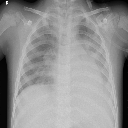

In [30]:
random_image(X_train, np.argmax(y_train, axis=1), verbose=1)

#### Baseline Model

In [31]:
# Creating and fitting our dummy classifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

# Creating our y_pred variable
y_pred = dummy.predict(X_test)

# We need to one-hot encode our classes from our generated labels in order for
# The confusion matrix to be able to digest any of it
y_pred = np.argmax(y_pred, axis=1)
y_test_ohe = np.argmax(y_test, axis=1)

              precision    recall  f1-score   support

           0       0.27      0.51      0.36       240
           1       0.33      0.26      0.29       269
           2       0.29      0.13      0.18       270

    accuracy                           0.29       779
   macro avg       0.30      0.30      0.28       779
weighted avg       0.30      0.29      0.27       779



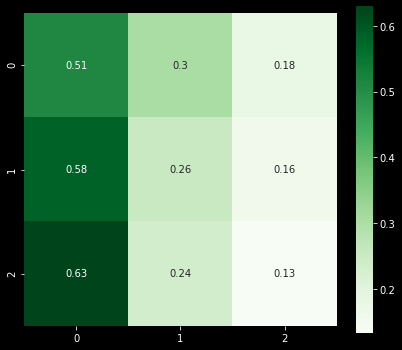

In [32]:
#Printing classification report and plotting confusion matrix
print(metrics.classification_report(y_test_ohe, y_pred));

plt.figure(figsize=(7, 6))
cm = metrics.confusion_matrix(y_test_ohe, y_pred, labels = [0, 1, 2], 
                              normalize='true')
sns.heatmap(cm, cmap="Greens", annot=True, square=True)
plt.show()

We built a baseline dummy classifier model that has an accuracy of 34%, and it tends to guess for the class == 0, which is our Covid class.

Since our dataset is relatively balanced in terms of classes, we expect to see the accuracy be around 33%.

## First CNN Model for CXRs

Now we will create new generators that we will feed into a CNN model. Notice for the test generator we must set the parameter shuffle=False. This is because when we want to evaluate the model, we want be able to see the model's actual score against the test generator. If we were to set shuffle=True for the test generator, the labels in the test generator would not line up with the images when trying to evaluate the model.

In [33]:
# Creating generators for our model

train_generator = train_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=32,
                                                   class_mode='categorical')

test_generator = test_val_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=32,
                                                     class_mode='categorical', 
                                                     shuffle=False)

val_generator = test_val_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [34]:
# Defining input shape to feed into our CNN
INPUT_SHAPE = train_generator.image_shape

#### Viewing our Class Weights

In [36]:
class_weights_dict = make_class_weights(train_generator)

{0: 1.078968253968254, 1: 0.9662402274342573, 2: 0.963159759121502}


### Creating CNN Model

In [37]:
def create_basic_cnn(shape='',
                     metrics=['acc', tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall'), 
                              tf.keras.metrics.AUC(name='auc')]):
  """
  Definition:
  Creates a basic cnn model consisting of three layers and an output layer.

  Args:
  shape: this function requires an input shape in order for the model to be created.

  Returns:
  Returns a compiled model.
  """
  # We are requiring an input shape since we print the model.summary() at the 
  # end of the function
  if len(shape) < 1:
    print('Please define input shape!')
  else:
    # Input layer
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D((2, 2)))

    # Second layer
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
      
    # Third layer
    model.add(Flatten())
    model.add(layers.Dense(128, activation='relu'))
      
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())
    return model

In [38]:
basic_model = create_basic_cnn(shape=INPUT_SHAPE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7372928   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

### Fitting model, Plotting scores, Reporting evaluation

Epoch 1/5
85/85 [==============================] - 38s 404ms/step - loss: 0.8654 - acc: 0.6706 - precision: 0.7279 - recall: 0.5683 - auc: 0.8249 - val_loss: 0.2856 - val_acc: 0.8892 - val_precision: 0.8984 - val_recall: 0.8892 - val_auc: 0.9763
Epoch 2/5
85/85 [==============================] - 34s 397ms/step - loss: 0.2071 - acc: 0.9266 - precision: 0.9288 - recall: 0.9179 - auc: 0.9875 - val_loss: 0.1253 - val_acc: 0.9588 - val_precision: 0.9611 - val_recall: 0.9562 - val_auc: 0.9949
Epoch 3/5
85/85 [==============================] - 34s 399ms/step - loss: 0.1112 - acc: 0.9595 - precision: 0.9601 - recall: 0.9573 - auc: 0.9964 - val_loss: 0.1399 - val_acc: 0.9433 - val_precision: 0.9457 - val_recall: 0.9433 - val_auc: 0.9928
Epoch 4/5
85/85 [==============================] - 34s 396ms/step - loss: 0.0905 - acc: 0.9669 - precision: 0.9675 - recall: 0.9663 - auc: 0.9972 - val_loss: 0.1078 - val_acc: 0.9613 - val_precision: 0.9612 - val_recall: 0.9588 - val_auc: 0.9960
Epoch 5/5
85/85 

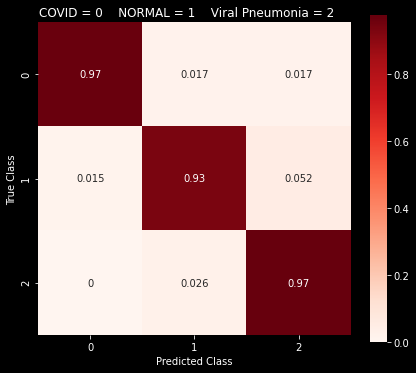

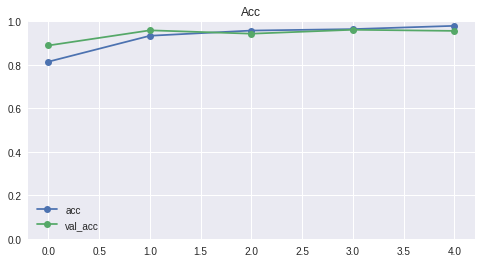

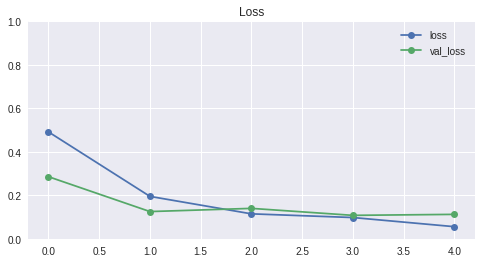

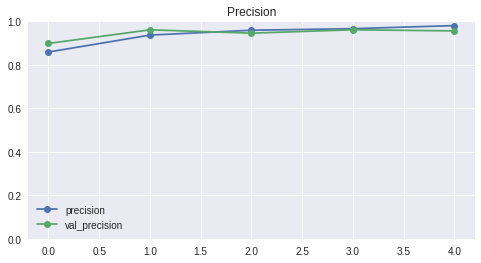

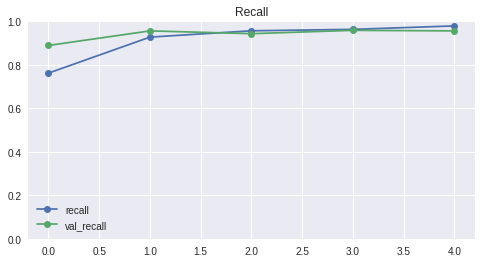

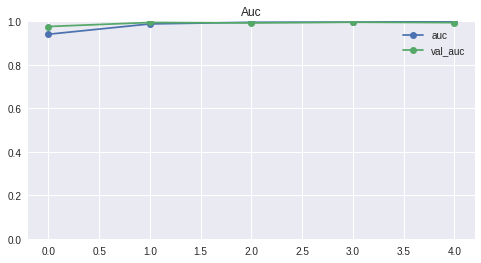

------------------------------------------------------------
25/25 [==============================] - 8s 349ms/step - loss: 0.1521 - acc: 0.9576 - precision: 0.9576 - recall: 0.9576 - auc: 0.9930
loss score: 0.15213921666145325
accuracy score: 0.9576380252838135
precision score: 0.9576380252838135
recall score: 0.9576380252838135
auc score: 0.9930368065834045

Time to run cell: 192 seconds


In [39]:
hist1 = fit_plot_report_gen(basic_model, train_generator, test_generator, val_generator, 
                class_weights=class_weights_dict, epochs=5, batch_size=32)

In [40]:
# removing unpreprocessed CXR train, test, and val folder directory
try:
  shutil.rmtree(cxr_folders)
except:
  pass

## CLAHE Preprocessing Techniques

Contrast Limited Adaptive Histogram Equalization (CLAHE) is used to equalize pixel intensity in images. It is very similar to Adaptive Histogram Equalization (AHE), except it doesn't over-amplify the contrast of the image. This is controlled by the clipLimit parameter. The way CLAHE works on an image is that it focuses on small portions of the image (tileGridSize parameter) and then combines these portions together through bilinear interpolation to help remove any artificial boundaries, which means that it enhances the local contrast of the total image. This essentially helps with the pixel intensity distribution, allowing us to see more "depth" in an image.

link for info on cv2.createCLAHE():
 - https://docs.opencv.org/master/d6/dc7/group__imgproc__hist.html#gad689d2607b7b3889453804f414ab1018

In [90]:
covid = ('Covid Class', 'COVID/COVID')
normal = ('Healthy Class', 'NORMAL/NORMAL')
pneumo = ('Viral Pneumonia Class', 'Viral Pneumonia/Viral Pneumonia')

In [91]:
class_select = input(f'Please select one of the classes to view: '
                     f'[covid][normal][pneumo] ')
if class_select == 'covid':
  selected_class = covid
elif class_select == 'normal':
  selected_class = normal
elif class_select == 'pneumo':
  selected_class = pneumo
try:
  # choosing a random image within the selected class folder
  i = np.random.choice(range(len(os.listdir(cxr_base_folder+selected_class[1].split('/')[0]))))
  img = cv2.imread(cxr_base_folder + selected_class[1] + f' ({i}).png', 0)
  print(f'Successfully loaded in an image from {selected_class[0]}')
  print(f"Image size: {img.shape}")
except:
  print('Error: No class with that name exists')

Please select one of the classes to view: [covid][normal][pneumo] covid
Successfully loaded in an image from Covid Class
Image size: (256, 256)


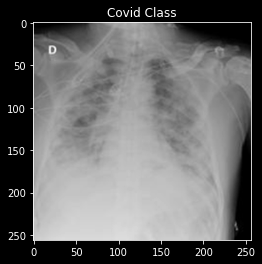

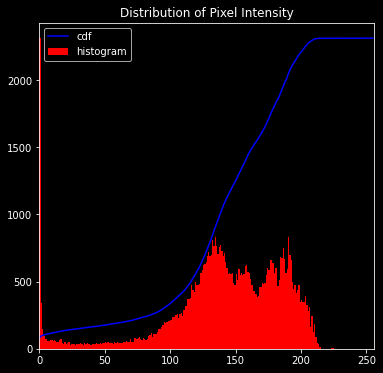

In [92]:
# Plotting an image to view, along with distribution of pixel intensity

plt.title(selected_class[0])
plt.imshow(img, cmap='gray')
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure(figsize=(6, 6))
plt.title('Distribution of Pixel Intensity')
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


As we can see here, the distribution of pixel intensity in our unpreprocessed image ranges from 0 to around 220.

### Creating CLAHE preprocessed images and placing them into new directory

In [106]:
# Please define a filepath where you would like the CLAHE preprocessed images to
# be stored in the 'new_folder' variable. This folder is temporary.

if os.path.exists(cxr_clahe_folder):
  print('CLAHE folder already exists')
else:
  cxr_clahe_folder = ensure_filepath('/content/clahe_radio')
  clahe_preprocessing(cxr_base_folder, cxr_clahe_folder)

CLAHE folder already exists


In [105]:
num_items(cxr_clahe_folder)

/content/clahe_radio/
Number of items in COVID: 1200
Number of items in NORMAL: 1341
Number of items in Viral Pneumonia: 1345
Total number of items: 3886


3886

In [107]:
orig_img = cv2.imread(cxr_base_folder + selected_class[1] + f' ({i}).png')
clahe_img = cv2.imread(cxr_clahe_folder + selected_class[1] + f' ({i}).png')

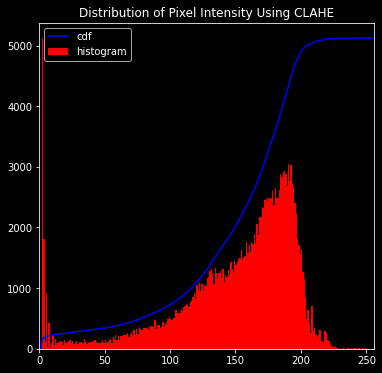

In [108]:
hist,bins = np.histogram(clahe_img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.figure(figsize=(6, 6))
plt.title('Distribution of Pixel Intensity Using CLAHE')
plt.plot(cdf_normalized, color = 'b')
plt.hist(clahe_img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


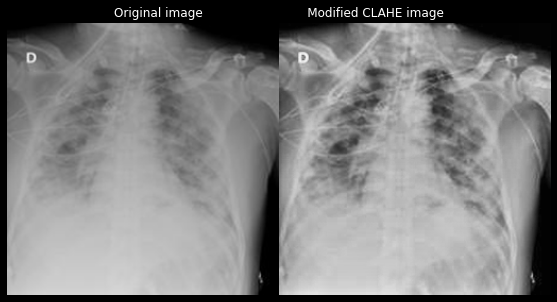

In [109]:
# Comparing original image (left) to CLAHE applied image (right)
res = np.hstack((orig_img,clahe_img))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.imshow(res, cmap='gray')
plt.title('Original image                           Modified CLAHE image')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()

We can definitely see more of the infiltrate in the lung areas of the chest x-ray. These infiltrate areas of the lung can determine whether or not a person has Pneumonia. We can definitely see more of the infiltrate in the lung areas of the chest x-ray. These infiltrate areas of the lung can determine whether or not a person has Pneumonia. According to Hosseiny et al., when there is radiographic appearances of multifocal ground glass opacity, linear opacities, and consolidation, these are usually seen in cases of coronavirus type infections, including COVID-19, SARS, and MERS.

In [ ]:
# Removing unpreprocessed images from our directory
try:
  shutil.rmtree(cxr_base_folder)
except:
  pass

In [ ]:
# Splitting our preprocess image folder into train, test, and validation subfolders
# in a new directory
clahe_ttv_folder = ensure_filepath('/content/clahe_ttv')

splitfolders.ratio(input=cxr_clahe_folder, 
                    output=clahe_ttv_folder, 
                    seed=42, ratio=(0.7, 0.1, 0.2)) # ratio of data sharing for
                                                    # train, test, val folders

Copying files: 3886 files [00:05, 668.36 files/s] 


In [ ]:
# Removing base clahe images folder from our directory
try:
  shutil.rmtree(cxr_clahe_folder)
except:
  pass

In [ ]:
folder_check(clahe_ttv_folder)

/content/clahe_ttv/train/
Number of items in Viral Pneumonia: 941
Number of items in NORMAL: 938
Number of items in COVID: 840
Total number of items: 2719

/content/clahe_ttv/test/
Number of items in Viral Pneumonia: 270
Number of items in NORMAL: 269
Number of items in COVID: 240
Total number of items: 779

/content/clahe_ttv/val/
Number of items in Viral Pneumonia: 134
Number of items in NORMAL: 134
Number of items in COVID: 120
Total number of items: 388


Total image count: 3886


## Modeling with CLAHE preprocessed images

Defining new folders for our preprocessed chest x-ray images

In [ ]:
train_folder, test_folder, val_folder = create_ttv(clahe_ttv_folder)

Defining image sizes for our preprocessed chest x-ray images

In [ ]:
# Still the same size as our previous model
IMG_SIZE = (128, 128)

In [ ]:
# We are still using the same imagedatagenerator as before to normalize our data,
# the 'train_datagen and test_val_datagen'
train_clahe_datagen = ImageDataGenerator(rescale=1./255)
                                         #width_shift_range=0.1, 
                                         #height_shift_range=0.1,
                                         #zoom_range=0.1, 
                                         #rotation_range=0.2)

test_val_clahe_datagen = ImageDataGenerator(rescale=1./255)

cl_train_generator = train_clahe_datagen.flow_from_directory(train_folder, 
                                                   target_size=IMG_SIZE,
                                                   batch_size=32,
                                                   class_mode='categorical')

cl_test_generator = test_val_clahe_datagen.flow_from_directory(test_folder, 
                                                     target_size=IMG_SIZE,
                                                     batch_size=32,
                                                     class_mode='categorical', 
                                                     shuffle=False)

cl_val_generator = test_val_clahe_datagen.flow_from_directory(val_folder, 
                                                    target_size=IMG_SIZE,
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 2719 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 388 images belonging to 3 classes.


In [ ]:
INPUT_SHAPE = cl_train_generator.image_shape
print(INPUT_SHAPE)

(128, 128, 3)


In [ ]:
class_weights_dict = make_class_weights(cl_train_generator)

{0: 1.078968253968254, 1: 0.9662402274342573, 2: 0.963159759121502}


In [ ]:
basic_prep_cnn = create_basic_cnn(shape=INPUT_SHAPE)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

Epoch 1/10
85/85 [==============================] - 27s 306ms/step - loss: 1.5853 - acc: 0.5668 - precision: 0.8524 - recall: 0.6549 - auc: 0.9025 - val_loss: 0.2048 - val_acc: 0.9201 - val_precision: 0.9247 - val_recall: 0.9175 - val_auc: 0.9877
Epoch 2/10
85/85 [==============================] - 25s 294ms/step - loss: 0.1709 - acc: 0.9345 - precision: 0.9382 - recall: 0.9301 - auc: 0.9908 - val_loss: 0.1212 - val_acc: 0.9691 - val_precision: 0.9691 - val_recall: 0.9691 - val_auc: 0.9947
Epoch 3/10
85/85 [==============================] - 25s 298ms/step - loss: 0.1289 - acc: 0.9531 - precision: 0.9572 - recall: 0.9489 - auc: 0.9950 - val_loss: 0.1974 - val_acc: 0.9227 - val_precision: 0.9251 - val_recall: 0.9227 - val_auc: 0.9874
Epoch 4/10
85/85 [==============================] - 25s 295ms/step - loss: 0.0640 - acc: 0.9789 - precision: 0.9793 - recall: 0.9766 - auc: 0.9982 - val_loss: 0.2173 - val_acc: 0.9278 - val_precision: 0.9278 - val_recall: 0.9278 - val_auc: 0.9851
Epoch 5/10
8

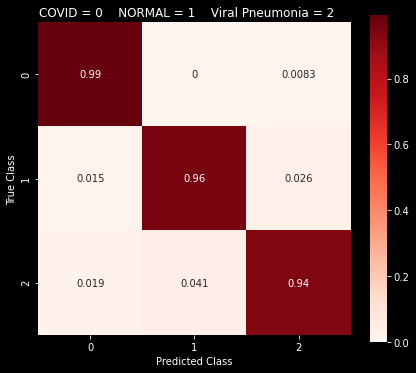

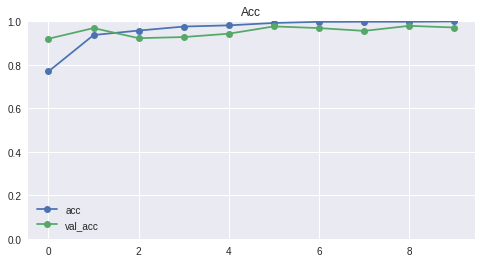

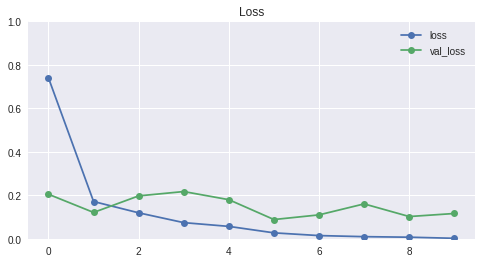

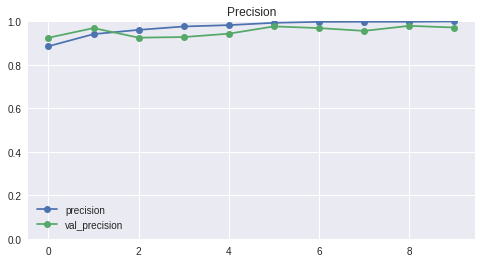

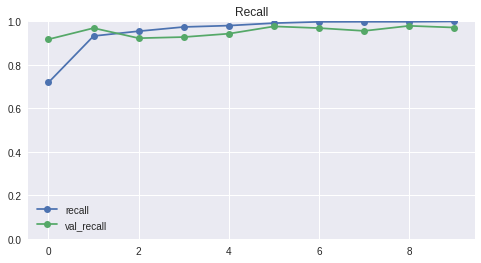

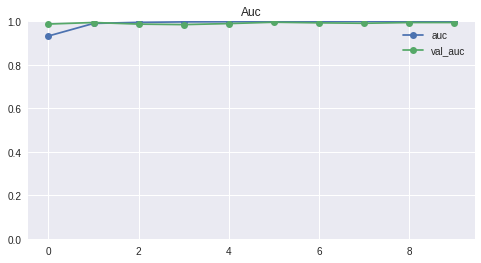

------------------------------------------------------------
25/25 [==============================] - 6s 254ms/step - loss: 0.1797 - acc: 0.9628 - precision: 0.9627 - recall: 0.9615 - auc: 0.9911
loss score: 0.17968153953552246
accuracy score: 0.962772786617279
precision score: 0.9627249240875244
recall score: 0.9614890813827515
auc score: 0.9910779595375061

Time to run cell: 268 seconds


In [ ]:
#Feel free to tweak the parameters of the three_callbacks() function. Make
# sure to read how the function works first.

"""
Recommended parameters to play around with:
 - epochs
 - lr_patience
 - factor
 - patience
 - restore_best_weights

Please read the three_callbacks() function before changing!

Note that: 
 - patience should not be lower than lr_patience, otherwise learning rate decay
 will not occur.
 - Both patience and lr_patience should not be as large / larger than the number 
 of epochs
"""

# Please define a filepath to store all models that will be saved from the 
# ModelCheckpoint callback in the variable 'cxr_model_storage'. 
cxr_model_storage = ensure_filepath('/cxr_models/')

prep_hist = fit_plot_report_gen(basic_prep_cnn, cl_train_generator, 
                                cl_test_generator, cl_val_generator, 
                                epochs=10, batch_size=32,
                                class_weights=class_weights_dict, 
                                callbacks=three_callbacks(lr_patience=3, factor=0.9, 
                                                          patience=5, 
                                                          restore_best_weights=False,
                                                          f_path=cxr_model_storage))

#### Creating lime image explainer

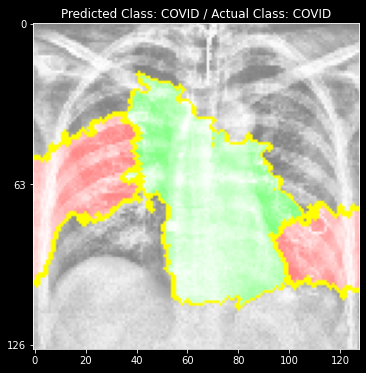

In [ ]:
explain_image(basic_prep_cnn, cl_train_generator, num_samples=2000, num_feats=3, 
              class_label=0)

### Saving best CXR models

In [ ]:
# Please set a filepath for the 'best_models_filepath' variable where you would
# like to store your best models
# Feel free to change the threshold, not that the lower the threshold, the more
# models will be saved to the 'best_models_filepath'.

best_models_filepath = ensure_filepath('/content/drive/MyDrive/gdrive/models/capstone_models/cxr_models/')
THRESHOLD = 0.96

move_best_models(source=cxr_model_storage, threshold=THRESHOLD,
                 new_dir=best_models_filepath, 
                 test_gen=cl_test_generator)

25/25 [==============================] - 7s 259ms/step - loss: 0.1352 - acc: 0.9564 - precision: 0.9624 - recall: 0.9538 - auc: 0.9939


---------------------------------------------------------
                  Classification Report

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       240
           1       0.95      0.98      0.96       269
           2       0.98      0.94      0.96       270

    accuracy                           0.97       779
   macro avg       0.97      0.97      0.97       779
weighted avg       0.97      0.97      0.97       779

---------------------------------------------------------


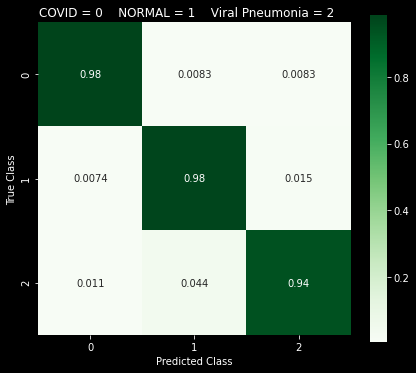

25/25 [==============================] - 7s 258ms/step - loss: 0.1188 - acc: 0.9679 - precision: 0.9704 - recall: 0.9679 - auc: 0.9941


[0.11884351074695587,
 0.9679075479507446,
 0.9703989624977112,
 0.9679075479507446,
 0.994138777256012]

In [ ]:
# To load in a model, please find the filepath for a saved model and put into 
# the 'model_fpath' variable.

model_fpath = '/content/drive/MyDrive/gdrive/models/capstone_models/cxr_models/model-05-0.101.hdf5'

best_model = load_model(model_fpath)
class_report_gen(best_model, cl_test_generator, 
                 class_indices=test_generator.class_indices, cmap='Greens')
best_model.evaluate(cl_test_generator, verbose=1)

## Recommendation: 
When working with images like x-rays or MRI scans, I highly recommend using CLAHE as a preprocessing technique to create new images that give the model more to learn from. CLAHE also is able to provide enough contrast to the image without overamplifying the intensity of the pixels. It is a great tool if the goal of your project involve detection and/or recognition.

In [1]:
# If you are finished with the above section and would like to continue, please
# set run = 1 to remove unecessary folders for Part 2
ans = input(f"All temporary files from Part 1 will be removed from the working "
            f"directory. Proceed? [y][n] ")
if ans.lower() == 'y':
  print("Removing files")
  try:
    shutil.rmtree(clahe_ttv_folder)
    shutil.rmtree(cxr_model_storage)
    print("Process completed")
  except:
    print("No folders were removed")
else:
  print("No folders were removed")

Would you like to continue to Part 2? All temporary files from Part 1 will be removed from the working directory. [y][n] n


# Interpretation



While using x-rays to diagnose patients with COVID has proven to be successful with the model we've created, the process of each person getting an x-ray to determine if they have COVID can be costly. Furthermore, we wouldn't want someone with COVID to come into a facility and expose healthy people to the virus. So for Part 2, we are going to explore the possiblities of using cough audio from healthy and COVID infected individuals and see if we can create a model that can accurately diagnose those with COVID. 

## References

1. M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.

2. Lara Orlandic, Tomas Teijeiro, & David Atienza. (2020). The COUGHVID crowdsourcing dataset: A corpus for the study of large-scale cough analysis algorithms (Version 1.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4048312

3. Chaudhari, Gunvant, et al. "Virufy: Global Applicability of Crowdsourced and Clinical Datasets for AI Detection of COVID-19 from Cough." arXiv preprint arXiv:2011.13320 (2020).

4. Hosseiny M, Kooraki S, Gholamrezanezhad A, Reddy S, Myers L. Radiology Perspective of Coronavirus Disease 2019 (COVID-19): Lessons From Severe Acute Respiratory Syndrome and Middle East Respiratory Syndrome. AJR Am J Roentgenol2020;214:1078-82. doi:10.2214/AJR.20.22969 pmid:32108495

## Part 2

Link to Part 2: https://colab.research.google.com/drive/1s4z-GJnNkE2NCx5MVccXxXzvBIc__tTX#scrollTo=WjwyDrj8S80W